In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import sys
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
import operator
import json
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from scipy import spatial
import os
import pickle

#### Loading the JSON file from the dataframe

In [ ]:
#The whole path will have to be specified for colab
basePath = "/content/drive/My Drive/BiLSTM model/"
news_df = pd.read_json(basePath + "IndianNews_Dataset_for_glove_embeddings.json", orient ='split', compression = 'infer')
news_df.shape

(25524, 7)

#### Loading the updated glove embeddings

In [ ]:
#Loading the pickled embeddings:
with open(basePath + 'updated_embeddings.pickle', 'rb') as handle:
    glove_embeddings_dict = pickle.load(handle)

In [ ]:
sys.getsizeof(glove_embeddings_dict)

83886184

# Data Preparation

## Converting the target column to numbers

In [ ]:
#Creating a dictionary to change the values of the Ideology column
#Note that the number have to start from 0 to use the keras to_categorical() function
id_dict = {'centre': 0, 'left': 1, 'right': 2}

In [ ]:
#Checking the values in this column before mapping
news_df['Ideology'].unique()

array(['centre', 'left', 'right'], dtype=object)

In [ ]:
#Using the dictionary to change the values in the column
news_df['Ideology'] = news_df['Ideology'].map(id_dict)
news_df['Ideology'].unique()

array([0, 1, 2])

## Splitting the data into test and train sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(news_df.drop(['Ideology'], axis=1), news_df['Ideology'], 
                                                    test_size=0.25, random_state=100, stratify = news_df['Ideology'])

Next, splitting the train set into train and validation sets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=100, stratify = y_train)

In [ ]:
print("Train set size: ", X_train.shape[0])
print("Test set size: ", X_test.shape[0])
print("Validation set size: ", X_val.shape[0])

Train set size:  15314
Test set size:  6381
Validation set size:  3829


In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
#Converting the y_... objects from Series to Dataframes
y_train = pd.DataFrame({'Ideology': y_train})
y_test = pd.DataFrame({'Ideology': y_test})
y_val = pd.DataFrame({'Ideology': y_val})

Let's check the number of words in articles and the number of sentences in articles.

In [ ]:
#Checking the number of words in articles
pd.Series([len(i.split()) for i in news_df['Title+Article']]).describe()

count    25524.000000
mean       614.946952
std        291.902585
min        216.000000
25%        400.000000
50%        536.000000
75%        755.000000
max       1770.000000
dtype: float64

In [ ]:
#Checking the number of sentences in articles
pd.Series([len(i.split('.')) for i in news_df['Title+Article']]).describe()

count    25524.000000
mean        25.587800
std         13.577909
min          4.000000
25%         16.000000
50%         22.000000
75%         32.000000
max        189.000000
dtype: float64

For now, let's construct a model for the whole article.

# Model Building

Loading the libraries required for data preparation and model building

In [ ]:
import tensorflow as tf
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional, TimeDistributed, Flatten, Activation, Conv1D, CuDNNLSTM, BatchNormalization
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, Add, concatenate, SpatialDropout1D, Input, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
import logging
#import absl.logging
logging.basicConfig(level=logging.INFO)
#absl.logging.set_verbosity(absl.logging.ERROR)

## Tokenizing and Embedding text

Let's load and fit the tokenizer.

In [ ]:
#Using the keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(news_df['Title+Article'])

The Tokenizer indexes all the words in the text and assigns an index value to each word. This helps in creating a dictionary that maps words to an index.

In [ ]:
words_to_index = tokenizer.word_index

words_to_index is the dictionary that maps words to their indices.

Let's create an embedding matrix by using the glove embeddings.

In [ ]:
#Gettting the length of the vocabulary
vocab_len = len(words_to_index)

#Getting the dimensions of glove embeddings by using a common word
embed_vector_len = glove_embeddings_dict['the'].shape[0]

#Creating an embedding matrix and filling it with zeros
embed_matrix = np.zeros((vocab_len, embed_vector_len))

#Looping through the words in our vocabulary and finding glove embeddings for them (where available)
for word, index in words_to_index.items():

  #Fetching the embedding value for a word
  embedding_vector = glove_embeddings_dict.get(word)

  #Making sure that an embedding exists for this word
  if embedding_vector is not None:
    embed_matrix[index, :] = embedding_vector


In [ ]:
#Checking the shape of the embedding matrix
embed_matrix.shape

(89859, 300)

In [ ]:
#Triggering garbage collection
gc.collect()

200

In [ ]:
#Defining the model architecture
def build_model(vocab_length, embedding_matrix, nclasses=3, MAX_SEQUENCE_LENGTH=512, EMBEDDING_DIM=300, dropout=0.25):

  #Adding an embedding layer
  #The embedding layer maps words to their embedding vectors from the embedding matrix (which contains glove embeddings). 
  #We can keep this layer as trainable, but let's change that value later on (as it increases the number of trainable parameters).
  
  inp = Input(shape = (MAX_SEQUENCE_LENGTH,))
  x = Embedding(vocab_length, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(inp)
  
  #Adding spatial dropout to the embedding layer
  x = SpatialDropout1D(0.5)(x)

  #Adding a Bi-LSTM layer
  #Setting return_sequences=True returns the hidden state output for each input time step
  x_bilstm = Bidirectional(CuDNNLSTM(512, return_sequences = True))(x)
  x = BatchNormalization()(x_bilstm)
  bilstm_layer = Dropout(dropout)(x)

  #Adding a 1D convolutional layer
  x_conv_1 = Conv1D(256, kernel_size=3, padding='valid', activation='relu', kernel_initializer='he_uniform')(bilstm_layer)
  x1 = BatchNormalization()(x_conv_1)
  x1 = Dropout(dropout)(x1)
  avgpool_conv_1 = GlobalAveragePooling1D()(x1)
  maxpool_conv_1 = GlobalMaxPooling1D()(x1)

  #Adding a second 1D convolutional layer
  x_conv_2 = Conv1D(256, kernel_size=5, padding='valid', activation='relu', kernel_initializer='he_uniform')(bilstm_layer)
  x2 = BatchNormalization()(x_conv_2)
  x2 = Dropout(dropout)(x2)
  avgpool_conv_2 = GlobalAveragePooling1D()(x2)
  maxpool_conv_2 = GlobalMaxPooling1D()(x2)

  #Adding a third 1D convolutional layer
  x_conv_3 = Conv1D(256, kernel_size=7, padding='valid', activation='relu', kernel_initializer='he_uniform')(bilstm_layer)
  x3 = BatchNormalization()(x_conv_3)
  x3 = Dropout(dropout)(x3)
  avgpool_conv_3 = GlobalAveragePooling1D()(x3)
  maxpool_conv_3 = GlobalMaxPooling1D()(x3)

  #Concatenating the output from the pooling layers
  x = concatenate([avgpool_conv_1, maxpool_conv_1, avgpool_conv_2, maxpool_conv_2, avgpool_conv_3, maxpool_conv_3])
                   
  #Flattening the data
  #x = Flatten()(x)

  #Adding a fully-connected layer
  x = Dense(512, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(dropout)(x)

  #Adding a softmax classification layer
  x = Dense(nclasses, activation = "softmax")(x)

  #Creating a model with these layers
  model = Model(inputs = inp, outputs = x)

  #Compiling the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #Printing the model summary
  model.summary()

  return model

Let's convert the text to sequences

In [ ]:
#Converting text to sequences
X_train_indices = tokenizer.texts_to_sequences(X_train['Title+Article'])

#Adding padding wherever the sequence length is < maxlen
X_train_indices = pad_sequences(X_train_indices, maxlen=512, padding='post')

X_train_indices.shape

(15314, 512)

Let's do the same for the validation data

In [ ]:
#Converting text to sequences
X_val_indices = tokenizer.texts_to_sequences(X_val['Title+Article'])

#Adding padding wherever the sequence length is < maxlen
X_val_indices = pad_sequences(X_val_indices, maxlen=512, padding='post')

X_val_indices.shape

(3829, 512)

The model also required onehotencoded data. Let's apply that change to the y dataframes.

In [ ]:
#Using the to_categorical feature in keras
train_labels = tf.keras.utils.to_categorical(y_train['Ideology'].values, num_classes=3)
val_labels = tf.keras.utils.to_categorical(y_val['Ideology'].values, num_classes=3)

In [ ]:
#Checking the vocab length
len(words_to_index)

89859

In [ ]:
basePath="/content/drive/My Drive/Thesis stuff/Bi-LSTM+CNN/"
basePath

'/content/drive/My Drive/Thesis stuff/Bi-LSTM+CNN/'

In [ ]:
#Creating a function to plot a model's graphs
def plot(history, model_num):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['Training Loss','Validation Loss'])
    axes[0].set_title("Loss")
    
    axes[1].plot(history.history['accuracy'])   
    axes[1].plot(history.history['val_accuracy'])
    axes[1].legend(['Training acc','Validation acc'])
    axes[1].set_title("Accuracy")
    
    plt.suptitle("Model " + str(model_num), fontsize = 16)

In [ ]:
#Setting the path where the model weights should be saved
checkpoint_path = basePath + "saved models/model_1/cp-model.ckpt"

In [ ]:
#Creating callbacks for saving the model and for early stopping
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_weights_only=True, 
                                                 save_freq='epoch', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, verbose=1)

In [ ]:
#Passing the vocab length, final embedding matrix, and number of classes and building a model
model_bilstm_cnn_22 = build_model(len(words_to_index), embed_matrix, dropout=0.4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 300)     26957700    ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 512, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 512, 1024)    3334144     ['spatial_dropout1d[0][0]']  

In [ ]:
train_history_22 = model_bilstm_cnn_22.fit(X_train_indices, train_labels,
                              validation_data=([X_val_indices, val_labels]),
                              epochs=25,
                              callbacks=[cp_callback, earlystopping],
                              batch_size=64,
                              verbose=1, 
                              shuffle=True)

Epoch 1/25
240/240 [==============================] - ETA: 0s - loss: 1.3225 - accuracy: 0.3798
Epoch 00001: val_accuracy improved from -inf to 0.37608, saving model to /content/drive/My Drive/Thesis stuff/Bi-LSTM+CNN/saved models/model_1/cp-model.ckpt
240/240 [==============================] - 311s 1s/step - loss: 1.3225 - accuracy: 0.3798 - val_loss: 1.4052 - val_accuracy: 0.3761
Epoch 2/25
240/240 [==============================] - ETA: 0s - loss: 1.0901 - accuracy: 0.4472
Epoch 00002: val_accuracy improved from 0.37608 to 0.37764, saving model to /content/drive/My Drive/Thesis stuff/Bi-LSTM+CNN/saved models/model_1/cp-model.ckpt
240/240 [==============================] - 273s 1s/step - loss: 1.0901 - accuracy: 0.4472 - val_loss: 1.1728 - val_accuracy: 0.3776
Epoch 3/25
240/240 [==============================] - ETA: 0s - loss: 1.0239 - accuracy: 0.4882
Epoch 00003: val_accuracy did not improve from 0.37764
240/240 [==============================] - 273s 1s/step - loss: 1.0239 - acc

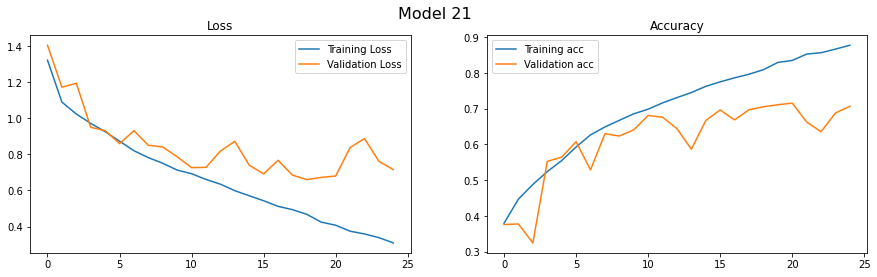

In [ ]:
plot(train_history_22, 22)